In [1]:
import jtap
jtap.set_jaxcache()
# from jtap.model import full_init_model, full_step_model, likelihood_model, stepper_model, get_render_args,is_ball_in_valid_position
# from jtap.inference import step_proposal, init_proposal, step_choicemap_translator, init_choicemap_translator, data_driven_size_and_position, sensor_reading_from_mo_vmap, effective_sample_size, normalize_log_weights, red_green_viz, get_rg_raw_beliefs
# from jtap.viz import rerun_jtap_stimulus, display_video, rerun_jtap_single_run
# from jtap.utils import load_red_green_stimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb

from jtap.core import SuperPytree
from jtap.distributions import uniformcat, labcat
from jtap.utils import discrete_lr_obs_to_rgb, init_step_concat, concat_pytrees, stack_pytrees
from jtap.viz import rerun_jtap_stimulus, display_video

# Standard library imports
from functools import partial

# Third-party imports
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.debug import print as jprint
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import rerun as rr

# GenJAX imports
import genjax
from genjax import gen, Pytree, ExactDensity, ChoiceMapBuilder as C

In [2]:
# Note: this is a continuous model

@Pytree.dataclass
class LR_Hyperparams(SuperPytree):
    # Assume scene height is 1
    max_speed: jnp.ndarray = SuperPytree.field()
    diameter: jnp.ndarray = SuperPytree.field()
    left_right_labels: jnp.ndarray = SuperPytree.field()
    masked_occluders: jnp.ndarray = SuperPytree.field() # N by 2 array of [x, length] occluder values
    pix_x: jnp.ndarray = SuperPytree.field()
    pix_y: jnp.ndarray = SuperPytree.field()
    pos_noise_std: jnp.ndarray = SuperPytree.field()
    speed_noise_std: jnp.ndarray = SuperPytree.field()
    direction_flip_prob: jnp.ndarray = SuperPytree.field()
    scene_length: jnp.ndarray = SuperPytree.static() # length 0 is the left edge, length scene_length is the right edge
    pixel_density: jnp.ndarray = SuperPytree.static()
    num_occluders: jnp.ndarray = SuperPytree.static()

    def __eq__(self, other) -> bool:
        if jax.tree_util.tree_structure(self) != jax.tree_util.tree_structure(other):
            return False
        leaves1 = jax.tree_util.tree_leaves(self)
        leaves2 = jax.tree_util.tree_leaves(other)
        bools = [jnp.all(l1 == l2) for l1, l2 in zip(leaves1, leaves2)]
        return jnp.all(jnp.array(bools))
    
    @classmethod
    def create(cls, **kwargs):
        scene_length = kwargs['scene_length']
        pixel_density = kwargs['pixel_density']

        pix_x = jnp.array(np.linspace(0, scene_length, (pixel_density * scene_length).astype(np.int32), endpoint=False))
        pix_y = jnp.array(np.linspace(0, 1, (pixel_density).astype(np.int32), endpoint=False))

        num_occluders = kwargs['masked_occluders'].shape[0]

        return cls(
            **kwargs,
            pix_x=pix_x,
            pix_y=pix_y,
            num_occluders=num_occluders
        )
        

@Pytree.dataclass
class LR_State(SuperPytree):
    hypers: LR_Hyperparams 
    x: jnp.ndarray
    speed: jnp.ndarray
    direction: jnp.ndarray
    hit_boundary: jnp.ndarray
    
@Pytree.dataclass
class LR_RenderArgs(SuperPytree):
    x: jnp.ndarray = SuperPytree.field()
    diameter: jnp.ndarray = SuperPytree.field()
    masked_occluders: jnp.ndarray = SuperPytree.field()
    pix_x: jnp.ndarray = SuperPytree.field()
    pix_y: jnp.ndarray = SuperPytree.field()
    num_occluders: jnp.ndarray = SuperPytree.static()
    pixel_density: jnp.ndarray = SuperPytree.static()


@gen
def lr_init_model(hypers: LR_Hyperparams):

    max_speed = hypers.max_speed
    scene_length = hypers.scene_length
    diameter = hypers.diameter
    left_right_labels = hypers.left_right_labels
    speed = genjax.uniform(jnp.float32(0.), max_speed) @ "speed"
    direction = uniformcat(left_right_labels) @ "direction" # -1 is left, 1 is right

    x = genjax.uniform(jnp.float32(0.), scene_length - diameter) @ "x"

    hit_boundary = (x <= 0) | (x >= scene_length - diameter)

    return LR_State(
        hypers=hypers,
        x=x,
        speed=speed,
        direction=direction,
        hit_boundary=hit_boundary
    )
    
lr_init_simulate = lr_init_model.simulate
lr_init_jsimulate = jax.jit(lr_init_model.simulate)
lr_init_importance = lr_init_model.importance
lr_init_jimportance = jax.jit(lr_init_model.importance)

@gen
def lr_stepper_model(state: LR_State):
    # NOTE: need to discuss: what is the causal model here?

    epsilon = jnp.float32(1e-6)

    x = state.x
    speed = state.speed
    direction = state.direction
    max_speed = state.hypers.max_speed
    diameter = state.hypers.diameter
    scene_length = state.hypers.scene_length
    pos_noise_std = state.hypers.pos_noise_std
    speed_noise_std = state.hypers.speed_noise_std
    direction_flip_prob = state.hypers.direction_flip_prob

    # this one line is the "physics" of the model
    x_mean = x + (speed * direction)

    # we have to make sure that the ball does not go out of bounds. If it does, then we record it in the state and clip it to the boundary
    hit_boundary = (x_mean <= 0) | (x_mean >= scene_length - diameter)
    x_mean = jnp.clip(x_mean, epsilon, scene_length - diameter - epsilon)

    # then we sample the position from the truncated normal distribution
    x = genjax.truncated_normal(x_mean, pos_noise_std, jnp.float32(0.), scene_length - diameter) @ "x"
    speed = genjax.truncated_normal(speed, speed_noise_std, jnp.float32(0.), max_speed) @ "speed"
    direction = direction_flip_distribution(direction, direction_flip_prob) @ "direction"

    return LR_State(
        hypers=state.hypers,
        x=x,
        speed=speed,
        direction=direction,
        hit_boundary=hit_boundary
    )

lr_stepper_simulate = lr_stepper_model.simulate
lr_stepper_jsimulate = jax.jit(lr_stepper_model.simulate)
lr_stepper_importance = lr_stepper_model.importance
lr_stepper_jimportance = jax.jit(lr_stepper_model.importance)

@jax.jit
def render_lr_scene(lr_render_args: LR_RenderArgs):
    """
    Render a 1D left-right scene with height=1.
    
    Args:
        x: position of the ball's left edge
        diameter: diameter of the ball
        masked_occluders: N by 2 array of [x_start, length] occluder values
        scene_length: total length of the scene
        pixel_density: pixels per unit length
    
    Returns:
        image: 2D array with shape (pixel_density, scene_length * pixel_density) where 0=background, 1=occluder, 2=target
    """
    # Create pixel grid for the scene

    x = lr_render_args.x
    diameter = lr_render_args.diameter
    num_occluders = lr_render_args.num_occluders
    masked_occluders = lr_render_args.masked_occluders
    pixel_density = lr_render_args.pixel_density
    pix_x = lr_render_args.pix_x
    pix_y = lr_render_args.pix_y

    num_pixels_x = pix_x.shape[0]
    num_pixels_y = pix_y.shape[0]

    # Create 2D meshgrid
    y_vals, x_vals = jnp.meshgrid(pix_y, pix_x, indexing='ij')
    
    # Initialize image with background (0)
    image = jnp.zeros((num_pixels_y, num_pixels_x), dtype=jnp.int8)
    
    r = diameter / 2
    # Calculate center coordinates by adding radius to position
    target_center_x_spatial = x + r
    target_center_y_spatial = r # center of ball is 0.5 always
    
    # Snap center to closest values in pix_x and pix_y arrays
    target_center_x = pix_x[jnp.argmin(jnp.abs(pix_x - target_center_x_spatial))]
    target_center_y = pix_y[jnp.argmin(jnp.abs(pix_y - target_center_y_spatial))]
    
    # Use a small epsilon to handle floating point precision issues
    distance_squared = (x_vals - target_center_x + 0.5*(1/pixel_density))**2 + (y_vals - target_center_y + 0.5*(1/pixel_density))**2
    r_squared = r**2
    
    image = jnp.where((distance_squared) < (r_squared), jnp.int8(2), image)

    # Render occluders (value 1)
    for i in range(num_occluders):
        occluder_x, occluder_length = masked_occluders[i]
        occluder_mask = (x_vals >= occluder_x) & (x_vals < occluder_x + occluder_length)
        image = jnp.where(occluder_mask, jnp.int8(1), image)

    return image

def get_lr_render_args(state: LR_State):
    return LR_RenderArgs(
        x=state.x,
        diameter=state.hypers.diameter,
        num_occluders=state.hypers.num_occluders,
        masked_occluders=state.hypers.masked_occluders,
        pixel_density=state.hypers.pixel_density,
        pix_x=state.hypers.pix_x,
        pix_y=state.hypers.pix_y
    )

@Pytree.dataclass
class DirectionFlipDistribution(ExactDensity):
    def sample(self, key, direction, direction_flip_prob, **kwargs):
        flip = jax.random.bernoulli(key, p = direction_flip_prob) * direction
        return jnp.where(flip, -direction, direction)

    def logpdf(self, x, direction, direction_flip_prob, **kwargs):
        same = (x == direction)
        flipped = (x == -direction)
        return jnp.where(
            same, jnp.log1p(-direction_flip_prob),  # log(1 - p)
            jnp.where(flipped, jnp.log(direction_flip_prob), -jnp.inf)
        )
    
direction_flip_distribution = DirectionFlipDistribution()

@Pytree.dataclass
class LR_PixelFlipLikelihood(ExactDensity):
    # HARDCODED TO HAVE 6 POSSIBLE PIXEL VALUES
    def sample(self, key, lr_render_args, flip_prob, *args, **kwargs):
        rendered_image = render_lr_scene(lr_render_args)
        
        # Apply pixel flip noise
        flip_key, noise_key = jax.random.split(key)
        
        # Determine which pixels to flip based on flip_prob
        flip_mask = jax.random.uniform(flip_key, rendered_image.shape) < flip_prob        
        
        # For each pixel, create a mask of valid alternatives (all values except the original)
        def sample_alternative_pixel(original_val, rng_key):
            # Instead of boolean indexing, use jnp.where to select alternatives
            # This avoids the NonConcreteBooleanIndexError
            alternatives = jnp.array([0, 1, 2], dtype=jnp.int8)
            # Remove the original value by setting its probability to 0
            probs = jnp.where(alternatives == original_val, 0.0, 1.0)
            # Normalize probabilities
            probs = probs / jnp.sum(probs)
            # Sample using categorical distribution
            return jax.random.choice(rng_key, alternatives, p=probs)
        
        # Generate noise keys for each pixel
        noise_keys = jax.random.split(noise_key, rendered_image.size)
        noise_keys = noise_keys.reshape(rendered_image.shape + (2,))
        
        # Apply pixel flipping
        flipped_values = jax.vmap(jax.vmap(sample_alternative_pixel))(
            rendered_image, noise_keys
        )
        
        # Return original where not flipped, alternative where flipped
        return jnp.where(flip_mask, flipped_values, rendered_image)

    def logpdf(self, obs_image, render_args, flip_prob, *args, **kwargs):
        return jnp.sum(
                # jnp.where(obs_image == render_scene(*render_args), jnp.log(1 - flip_prob), jnp.log(flip_prob/5))
                jnp.where(obs_image == render_scene(*render_args), jnp.log(1 - flip_prob), jnp.log(flip_prob))
        )
    
lr_pixel_flip_likelihood = LR_PixelFlipLikelihood()

In [18]:
# CONFIGURE THE FOLLOWING VARIABLES TO GENERATE STIMULI PROCEDURALLY

STIMULI_NAME = 'lr_v1'
FRAMES_PER_SECOND = 10
MAX_TRIAL_SECONDS = 12
SPEED = 0.5 # in units of ball diameters per FRAME (NOT seconds)
LEFT_RIGHT_LENGTH = 7 # in units of ball diameters
INITIAL_RANDOM_SEED = 42 # for reproducibility
DIRECTION_FLIP_PROB = 0.03
UNIFORM_STARTING_POSITION = True
REQUESTED_NUM_TRIALS = 700

BATCH_SIZE = 10000
TOTAL_NUM_TRIALS = 1000000

hypers = LR_Hyperparams.create(
    max_speed=jnp.float32(SPEED*2),
    diameter=jnp.float32(1.0),
    scene_length=jnp.float32(LEFT_RIGHT_LENGTH),
    pixel_density=jnp.float32(50.0),
    pos_noise_std=jnp.float32(0.0),
    speed_noise_std=jnp.float32(0.0),
    direction_flip_prob=jnp.float32(DIRECTION_FLIP_PROB),
    masked_occluders=jnp.array([[0,0]]), 
    left_right_labels=jnp.array([-1.0, 1.0])
)

# initialize the random number generator
key = jax.random.PRNGKey(INITIAL_RANDOM_SEED)

# get number of batches via a ceiling division
num_batches = (TOTAL_NUM_TRIALS + BATCH_SIZE - 1) // BATCH_SIZE

# get total num frames
total_num_frames = int(MAX_TRIAL_SECONDS * FRAMES_PER_SECOND)

# get mid point
mid_point = (LEFT_RIGHT_LENGTH / 2) - 0.5

# initialize the choice map over all batches
key, chm_key = jax.random.split(key)
batched_chms = []
if UNIFORM_STARTING_POSITION:
    for i in tqdm(range(num_batches), desc = 'setting choicemaps'):
        chm = C['x'].set((LEFT_RIGHT_LENGTH - 1) * jnp.float32(jax.random.uniform(chm_key, (BATCH_SIZE,))))
        chm = chm.at['speed'].set(jnp.full(BATCH_SIZE, jnp.float32(SPEED)))
        batched_chms.append(chm)
else:
    # set the starting position to the middle of the left-right track for all batches
    for i in tqdm(range(num_batches), desc = 'setting choicemaps'):
        chm = jax.vmap(lambda _: C['x'].set(jnp.float32(mid_point)))(jnp.arange(BATCH_SIZE))
        chm = chm.at['speed'].set(jnp.full(BATCH_SIZE, jnp.float32(SPEED)))
        batched_chms.append(chm)

batched_init_states = []
key, init_key = jax.random.split(key)
batch_init_keys = jax.random.split(init_key, num_batches)
for i in tqdm(range(num_batches), desc = 'initializing states'):
    all_batched_init_keys = jax.random.split(batch_init_keys[i], BATCH_SIZE)
    batched_trs, _ = jax.vmap(lr_init_importance, in_axes = (0, 0, None))(all_batched_init_keys, batched_chms[i], (hypers,))
    batched_init_states.append(batched_trs.retval)

def scan_inner_loop(carry, i):
    key, states = carry
    key, batch_simulate_key = jax.random.split(key)
    all_batch_simulate_keys = jax.random.split(batch_simulate_key, BATCH_SIZE)
    batched_states = jax.vmap(lr_stepper_simulate, in_axes = (0, 0))(all_batch_simulate_keys, (states,)).retval
    return (key, batched_states), batched_states

key, scan_key = jax.random.split(key)
batch_scan_keys = jax.random.split(scan_key, num_batches)

all_positions_over_time = []
all_hit_boundary_over_time = []
all_ending_indices = []
all_same_side_over_time = []
for i in tqdm(range(num_batches), desc = 'simulating states'):
    # this runs the simulations in a batched manner
    _, states_over_time = jax.lax.scan(scan_inner_loop, (batch_scan_keys[i], batched_init_states[i]), jnp.arange(total_num_frames))
    all_positions_over_time.append(np.array(init_step_concat(batched_init_states[i].x, states_over_time.x)))
    all_hit_boundary_over_time.append(np.any(states_over_time.hit_boundary, axis = 0))
    ending_indices = np.where(
          np.any(states_over_time.hit_boundary, axis=0), 
          np.argmax(states_over_time.hit_boundary, axis=0), 
          -1)
    all_ending_indices.append(ending_indices)
    if UNIFORM_STARTING_POSITION:
        started_left_side = batched_init_states[i].x <= mid_point
        ending_positions = states_over_time.x[ending_indices, jnp.arange(len(ending_indices))]
        ended_left_side = ending_positions <= mid_point
        all_same_side_over_time.append(np.array(ended_left_side) == np.array(started_left_side))

all_positions_over_time = np.concatenate(all_positions_over_time, axis = 1).T # N_trials X N_frames
all_hit_boundary_over_time = np.concatenate(all_hit_boundary_over_time, axis = 0) # N_trials
all_ending_indices = np.concatenate(all_ending_indices, axis = 0) # N_trials
if UNIFORM_STARTING_POSITION:
    all_same_side_over_time = np.concatenate(all_same_side_over_time, axis = 0) # N_trials

# Filter to only include trials that hit the boundary
total_trials = len(all_hit_boundary_over_time)
trials_that_hit = np.sum(all_hit_boundary_over_time)
percentage_hit = (trials_that_hit / total_trials) * 100

print(f"Generated {trials_that_hit} trials that ended within {MAX_TRIAL_SECONDS} seconds ({percentage_hit:.1f}% of {total_trials} total trials)")

# Index arrays by trials that hit boundary
all_positions_over_time = all_positions_over_time[all_hit_boundary_over_time]
all_ending_indices = all_ending_indices[all_hit_boundary_over_time]
if UNIFORM_STARTING_POSITION:
    all_same_side_over_time = all_same_side_over_time[all_hit_boundary_over_time]
all_hit_boundary_over_time = all_hit_boundary_over_time[all_hit_boundary_over_time]  # This will be all True now

setting choicemaps:   0%|          | 0/100 [00:00<?, ?it/s]

simulating states: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Generated 1000000 trials that ended within 12 seconds (100.0% of 1000000 total trials)


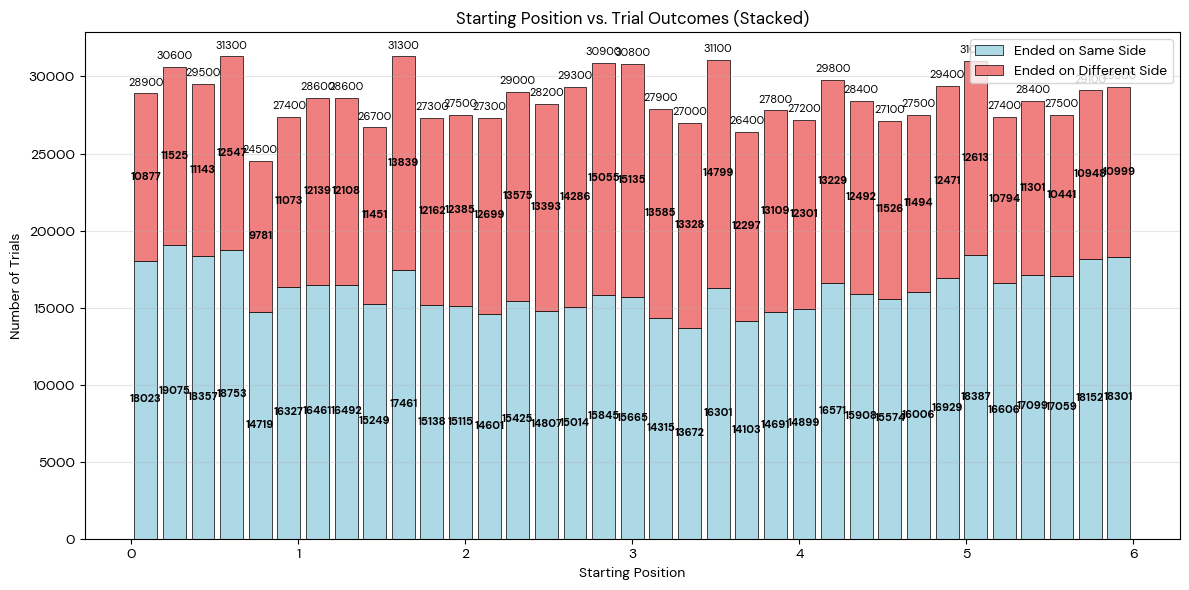

Total trials: 1000000
Trials ending on same side: 567100
Trials ending on different side: 432900
Proportion ending on same side: 0.567


In [19]:
import matplotlib.pyplot as plt

# Extract starting positions from the first frame of all_positions_over_time
starting_positions = all_positions_over_time[:, 0]

# Create bins for starting positions
num_bins = 5 * LEFT_RIGHT_LENGTH
bin_edges = np.linspace(starting_positions.min(), starting_positions.max(), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate counts for each bin
same_side_counts = []
different_side_counts = []
for i in range(num_bins):
    mask = (starting_positions >= bin_edges[i]) & (starting_positions < bin_edges[i+1])
    if i == num_bins - 1:  # Include the last edge for the final bin
        mask = (starting_positions >= bin_edges[i]) & (starting_positions <= bin_edges[i+1])
    
    if np.sum(mask) > 0:
        same_side_count = np.sum(all_same_side_over_time[mask])
        different_side_count = np.sum(~all_same_side_over_time[mask])
    else:
        same_side_count = 0
        different_side_count = 0
    
    same_side_counts.append(same_side_count)
    different_side_counts.append(different_side_count)

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
width = (bin_edges[1] - bin_edges[0]) * 0.8

bars1 = plt.bar(bin_centers, same_side_counts, width=width, 
                label='Ended on Same Side', color='lightblue', 
                edgecolor='black', linewidth=0.5)
bars2 = plt.bar(bin_centers, different_side_counts, width=width, 
                bottom=same_side_counts, label='Ended on Different Side', 
                color='lightcoral', edgecolor='black', linewidth=0.5)

plt.xlabel('Starting Position')
plt.ylabel('Number of Trials')
plt.title('Starting Position vs. Trial Outcomes (Stacked)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add count labels in the middle of each bar segment
for i, (center, same_count, diff_count) in enumerate(zip(bin_centers, same_side_counts, different_side_counts)):
    # Label for same side (bottom segment)
    if same_count > 0:
        plt.text(center, same_count / 2, str(same_count), 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Label for different side (top segment)
    if diff_count > 0:
        plt.text(center, same_count + diff_count / 2, str(diff_count), 
                ha='center', va='center', fontsize=8, fontweight='bold')

# Add total count labels on top of bars
total_counts = np.array(same_side_counts) + np.array(different_side_counts)
for i, (center, total) in enumerate(zip(bin_centers, total_counts)):
    if total > 0:
        plt.text(center, total + max(total_counts) * 0.01, str(total), 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Also show some summary statistics
print(f"Total trials: {len(starting_positions)}")
print(f"Trials ending on same side: {np.sum(all_same_side_over_time)}")
print(f"Trials ending on different side: {np.sum(~all_same_side_over_time)}")
print(f"Proportion ending on same side: {np.mean(all_same_side_over_time):.3f}")


In [ ]:
num_timesteps = 100

pixel_flip_prob = jnp.float32(0.0)

hypers = LR_Hyperparams.create(
    max_speed=jnp.float32(0.5),
    diameter=jnp.float32(1.0),
    scene_length=jnp.float32(13.0),
    pixel_density=jnp.float32(50.0),
    pos_noise_std=jnp.float32(0.0),
    speed_noise_std=jnp.float32(0.0),
    direction_flip_prob=jnp.float32(0.35),
    masked_occluders=jnp.array([[3.2,1.8], [7.1, 2.7]]), 
    left_right_labels=jnp.array([-1.0, 1.0])
)

key_idx = np.random.randint(0, 1e9)
# a nice key_idx is 850873184
key = jax.random.PRNGKey(key_idx)

chm = C['x'].set(jnp.float32(6.5))

states_over_time = []
discrete_obs_over_time = []

init_tr = lr_init_jimportance(key, chm, (hypers,))[0]
state = init_tr.get_retval() # init state
states_over_time.append(state)

key, _ = jax.random.split(key)
discrete_obs = lr_pixel_flip_likelihood.sample(key, get_lr_render_args(state), pixel_flip_prob)
discrete_obs_over_time.append(discrete_obs)

for i in tqdm(range(num_timesteps)):
    key, _ = jax.random.split(key)
    state = lr_stepper_jsimulate(key, (state,)).get_retval()
    states_over_time.append(state)

    key, likelihood_key = jax.random.split(key)
    discrete_obs = lr_pixel_flip_likelihood.sample(likelihood_key, get_lr_render_args(state), pixel_flip_prob)
    discrete_obs_over_time.append(discrete_obs)

    if state.hit_boundary:
        break

discrete_obs_over_time = np.array(discrete_obs_over_time)
rerun_jtap_stimulus(discrete_obs = discrete_obs_over_time, is_lr = True)

In [ ]:
display_video(discrete_lr_obs_to_rgb(discrete_obs_over_time), framerate = 10, skip_t = 1)

In [ ]:
num_time_lengths_to_sample = 100

pixel_flip_prob = jnp.float32(0.0)
scene_length = jnp.float32(13.0)

hypers = LR_Hyperparams.create(
    max_speed=jnp.float32(0.5),
    diameter=jnp.float32(1.0),
    scene_length=scene_length,
    pixel_density=jnp.float32(50.0),
    pos_noise_std=jnp.float32(0.0),
    speed_noise_std=jnp.float32(0.0),
    direction_flip_prob=jnp.float32(0.01),
    masked_occluders=jnp.array([[3.2,1.8], [7.1, 2.7]]), 
    left_right_labels=jnp.array([-1.0, 1.0])
)



time_lengths = []


for i in tqdm(range(num_time_lengths_to_sample)):

    key_idx = np.random.randint(0, 1e9)
    # a nice key_idx is 850873184
    key = jax.random.PRNGKey(key_idx)

    chm = C['x'].set(scene_length/2)

    states_over_time = []
    discrete_obs_over_time = []

    init_tr = lr_init_jimportance(key, chm, (hypers,))[0]
    state = init_tr.get_retval() # init state
    states_over_time.append(state)

    key, _ = jax.random.split(key)
    discrete_obs = lr_pixel_flip_likelihood.sample(key, get_lr_render_args(state), pixel_flip_prob)
    discrete_obs_over_time.append(discrete_obs)

    count = 0

    while True:
        key, _ = jax.random.split(key)
        state = lr_stepper_jsimulate(key, (state,)).get_retval()
        states_over_time.append(state)

        key, likelihood_key = jax.random.split(key)
        discrete_obs = lr_pixel_flip_likelihood.sample(likelihood_key, get_lr_render_args(state), pixel_flip_prob)
        discrete_obs_over_time.append(discrete_obs)

        count += 1

        if state.hit_boundary or count > 500:
            time_lengths.append(count)
            break

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(time_lengths, bins=100, alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Steps for Left-Right Task Trajectories (Flip Prob = 0.01)')
plt.xlabel('Time Length (number of steps)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
time_lengths